In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

## Solve ODE by PINN
We want to solve the following ODE boundary value problem by using Physucs informed neural network and compare it to the true solution and numerical solution.
$$ y^{''} = 2y^{'} + 3y -6 $$
$$y(0) = 3 , \quad y(1) = e^3 +2 $$
$$ y = e^{3x} +2$$

### solution function

In [10]:
def sol(x):
    return torch.exp(3*x) + 2

### building a simple PINN
We are going to build a simple neural network with different kind of random sampling and train it with the ODE constraints to see if the model actually learns

In [90]:
# the model
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()

        ])


        self.fch =nn.Sequential(*[ nn.Sequential(*[
            nn.Linear(N_HIDDEN, N_HIDDEN),
            activation()

        ]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN,N_OUTPUT)
        def weights_initialization(self):
                """"
                When we define all the modules such as the layers in '__init__()'
                method above, these are all stored in 'self.modules()'.
                We go through each module one by one. This is the entire network,
                basically.
                """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight,gain=1.0)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
 

C:\Users\abd-_\AppData\Local\Temp\ipykernel_4668\1774698730.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_exact = torch.tensor(sol(x = t_test))
C:\Users\abd-_\AppData\Local\Temp\ipykernel_4668\1774698730.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_physics = torch.tensor(sol(x = t_physics))


physics loss is :  42.5684700012207
Boundary loss is: 501.916748046875
total loss is: 18.18601417541504
MSE loss is  71.3929214477539


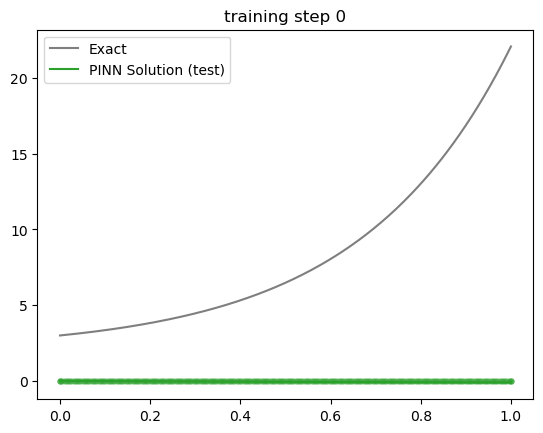

physics loss is :  0.5753782987594604
Boundary loss is: 375.1548156738281
total loss is: 3.8130977153778076
MSE loss is  31.41358184814453


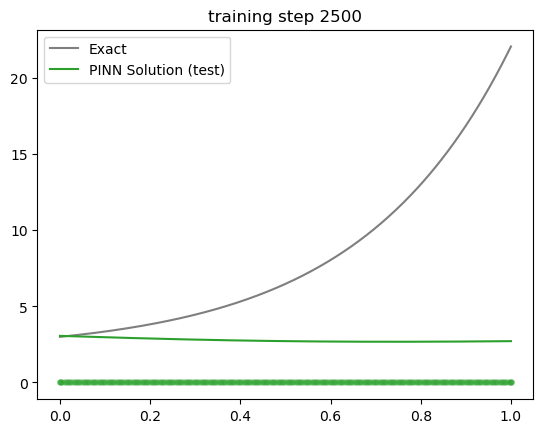

physics loss is :  1.1032702922821045
Boundary loss is: 359.9570617675781
total loss is: 3.7140793800354004
MSE loss is  30.257354736328125


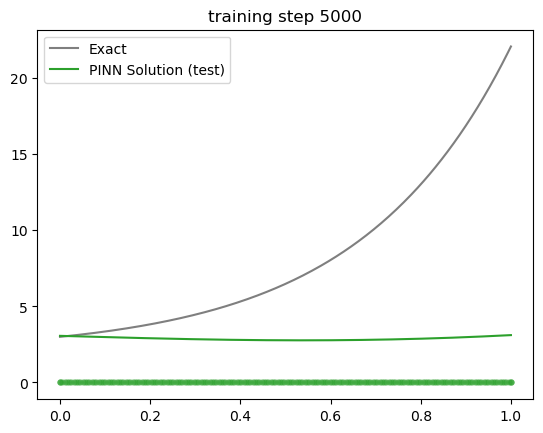

physics loss is :  0.09394662827253342
Boundary loss is: 35.580257415771484
total loss is: 0.36520472168922424
MSE loss is  3.021639823913574


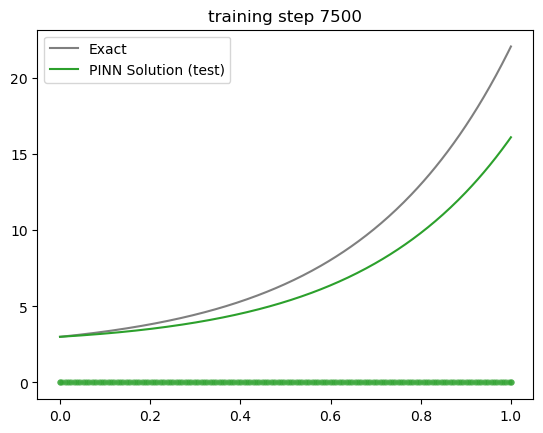

physics loss is :  0.0377221554517746
Boundary loss is: 2.5257670879364014
total loss is: 0.02903102897107601
MSE loss is  0.21439221501350403


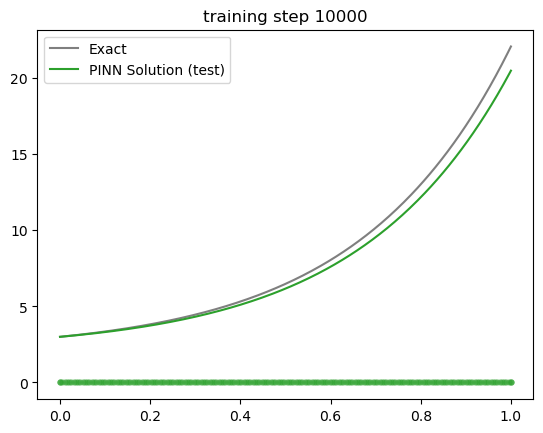

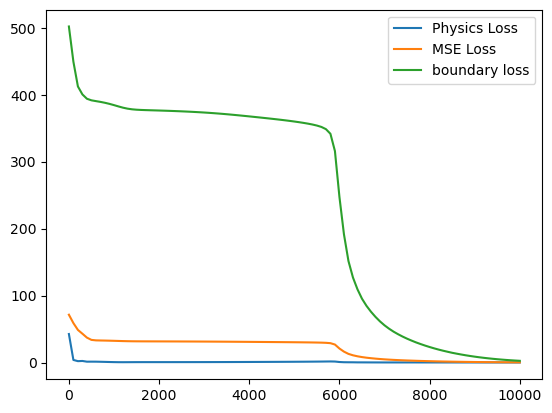

In [118]:
torch.manual_seed(123)
pinn = FCN(1,1,32,4)

t_boundary = torch.tensor([0.,1.], requires_grad = True).view(-1,1)
t_physics = torch.linspace(0,1,200, requires_grad = True).view(-1,1)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = torch.tensor(sol(x = t_test))
optimizer = torch.optim.Adam(pinn.parameters(), lr = 1e-4)
physics_loss = []
MSE_loss = []
iteration = []
boundary_loss = []
for i in range(10001):
    optimizer.zero_grad()
    lambda1, lambda2 = 1e-1, 1e-4

    # Boundary loss
    u = pinn(t_boundary)
    loss1 = torch.squeeze(u[0] -3)**2
    loss2 = torch.squeeze(u[1] - (np.exp(3) +2))**2
    
   # physics loss

    u = pinn(t_physics)
    du = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph = True)[0]
    du2 = torch.autograd.grad(du, t_physics, torch.ones_like(du), create_graph = True)[0]

    loss3 = torch.mean( (6 - 3*u - 2*du + du2)**2  )

    loss = loss1 + 1e-2* loss2 + 1e-1* loss3
    u_physics = torch.tensor(sol(x = t_physics))
    #points_loss = nn.MSELoss()
    #loss = points_loss(u_physics, u)
    loss.backward()
    optimizer.step()
    if i % 100 == 0: 
        boundary_loss.append(loss1.detach() + loss2.detach())
        physics_loss.append(loss3.detach())
        MSE_loss.append((torch.mean(u- u_physics)**2).detach())
        iteration.append(i)
    if i % 2500 == 0:
        print(f"physics loss is :  {loss3}")
        print(f"Boundary loss is: {loss1+loss2}")
        print(f"total loss is: {loss}")
        print(f"MSE loss is  {torch.mean(u- u_physics)**2}")
        u = pinn(t_test).detach()
        #plt.figure(figsize = (6,2,5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0],s=20,lw=0, color = "tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0],s=20,lw=0, color = "tab:green", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0],label = "Exact",color = "tab:grey")
        plt.plot(t_test[:,0], u[:,0], label = "PINN Solution (test)", color = "tab:green")
        #plt.plot(t_physics.detach()[:,0], u.detach()[:,0], label = "PINN Solution (train)", color = "tab:blue")
        plt.title(f"training step {i}")
        plt.legend()
        plt.show()

plt.plot(iteration,physics_loss, label = "Physics Loss")
plt.plot(iteration, MSE_loss, label = "MSE Loss")
plt.plot(iteration, boundary_loss, label = "boundary loss")
plt.legend()
plt.show()



### Another ODE 
Let us investigate the following ODE 
$$ y^{''} = -4y + 4x$$
$$y(0) = 0, \quad y^{'}(0) = -2$$ 
$$ y(x) = x - sin(2x)$$

In [74]:
def sol1(x):
    return x - torch.sin(2*x)

C:\Users\abd-_\AppData\Local\Temp\ipykernel_4668\158602023.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_physics = torch.tensor(sol1(x = t_physics))


physics loss is :  55.39057922363281
MSE loss is  2.607562780380249


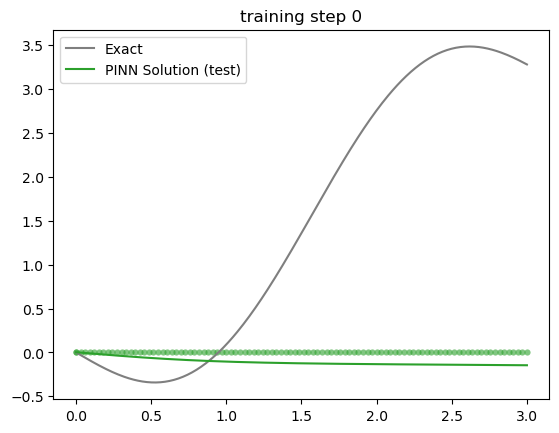

physics loss is :  0.5686291456222534
MSE loss is  0.00331895868293941


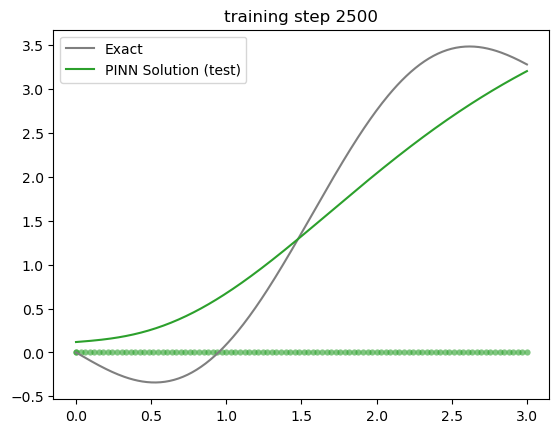

physics loss is :  0.3418113589286804
MSE loss is  0.002774252323433757


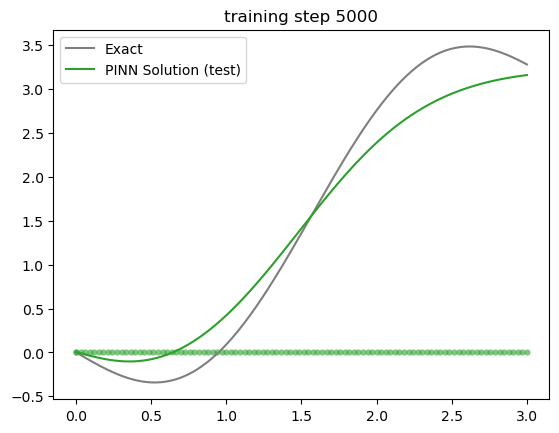

physics loss is :  0.0008493151981383562
MSE loss is  1.5911755326669663e-05


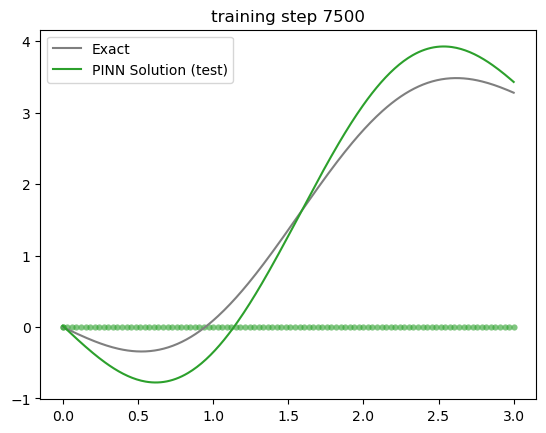

physics loss is :  4.3998115870635957e-05
MSE loss is  7.649651706742588e-06


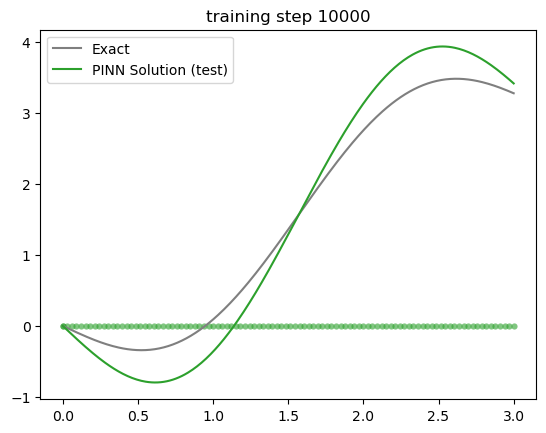

physics loss is :  1.748009708535392e-05
MSE loss is  6.70999315843801e-06


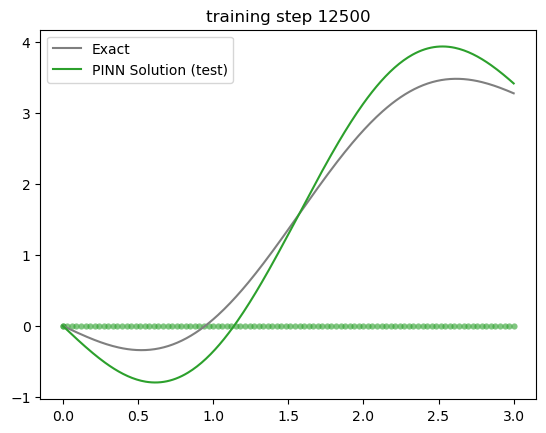

physics loss is :  1.1400305993447546e-05
MSE loss is  7.359836672549136e-06


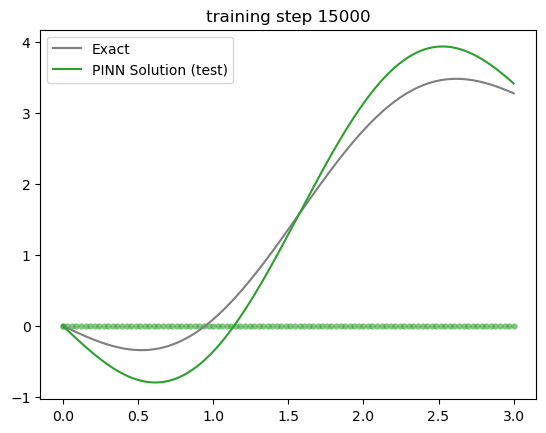

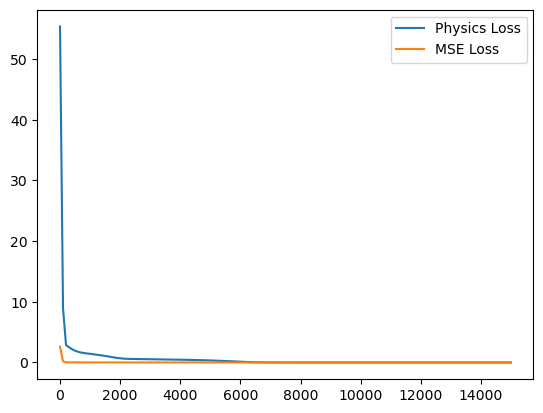

In [117]:
torch.manual_seed(123)
pinn = FCN(1,1,32,4)

t_boundary = torch.tensor(0., requires_grad = True).view(-1,1)

t_physics = torch.linspace(0,3,100, requires_grad = True).view(-1,1)
t_test = torch.linspace(0,3,300).view(-1,1)
u_exact = sol1(x = t_test)
optimizer = torch.optim.Adam(pinn.parameters(), lr = 1e-4)
physics_loss = []
MSE_loss = []
iteration = []
for i in range(15001):
    optimizer.zero_grad()
    lambda1, lambda2 = 1e-1, 1e-4

    # Boundary loss
    u = pinn(t_boundary)

    loss1 = torch.squeeze((u)**2)
    du = torch.autograd.grad(u,t_boundary, torch.ones_like(u), create_graph = True)[0]
    loss2 = torch.squeeze((du+2)**2)
   # physics loss

    u = pinn(t_physics)
    du = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph = True)[0]
    du2 = torch.autograd.grad(du, t_physics, torch.ones_like(du), create_graph = True)[0]

    loss3 = torch.mean( (du2+ 4*u - 4*t_physics)**2 )

    loss = lambda1* loss1 + lambda1* loss2 +  loss3
    u_physics = torch.tensor(sol1(x = t_physics))
    #points_loss = nn.MSELoss()
    #loss = points_loss(u_physics, u)
    loss.backward()
    optimizer.step()
    if i % 100 == 0: 
        physics_loss.append(loss.detach())
        MSE_loss.append((torch.mean(u- u_physics)**2).detach())
        iteration.append(i)
    if i % 2500 == 0:
        print(f"physics loss is :  {loss}")
        print(f"MSE loss is  {torch.mean(u- u_physics)**2}")

        u = pinn(t_test).detach()
        #plt.figure(figsize = (6,2,5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0],s=20,lw=0, color = "tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0],s=20,lw=0, color = "tab:green", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0],label = "Exact",color = "tab:grey")
        plt.plot(t_test[:,0], u[:,0], label = "PINN Solution (test)", color = "tab:green")
        #plt.plot(t_physics.detach()[:,0], u.detach()[:,0], label = "PINN Solution (train)", color = "tab:blue")
        plt.title(f"training step {i}")
        plt.legend()
        plt.show()

plt.plot(iteration,physics_loss, label = "Physics Loss")
plt.plot(iteration, MSE_loss, label = "MSE Loss")
plt.legend()
plt.show()

### Ben Modeley Example, Dumped oscillater 


In [77]:
def exact_solution(d,w0,t):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

physics loss is :  0.9130856394767761
MSE loss is  0.0005304171936586499


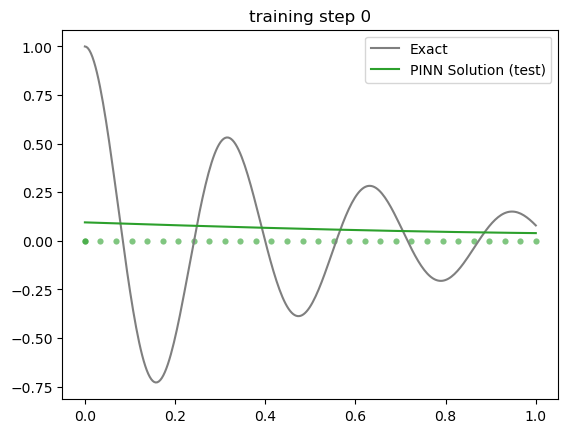

physics loss is :  0.0002302133070770651
MSE loss is  0.0003298770170658827


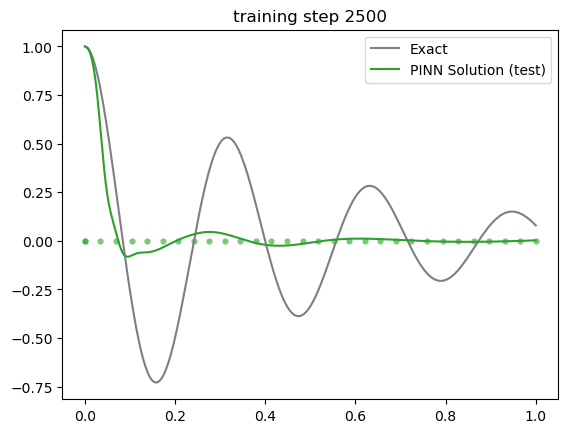

physics loss is :  9.97502647805959e-05
MSE loss is  0.0005003357073292136


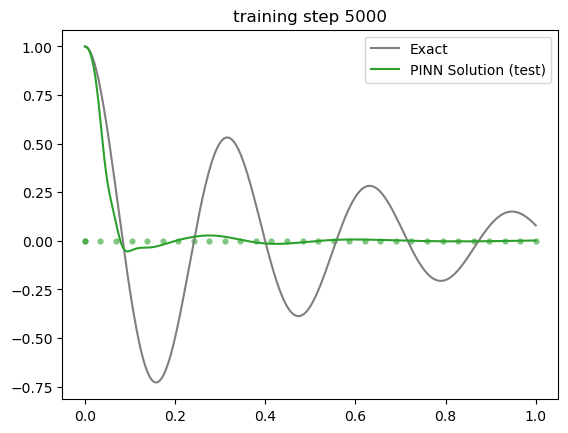

physics loss is :  5.669799429597333e-05
MSE loss is  0.0006029254291206598


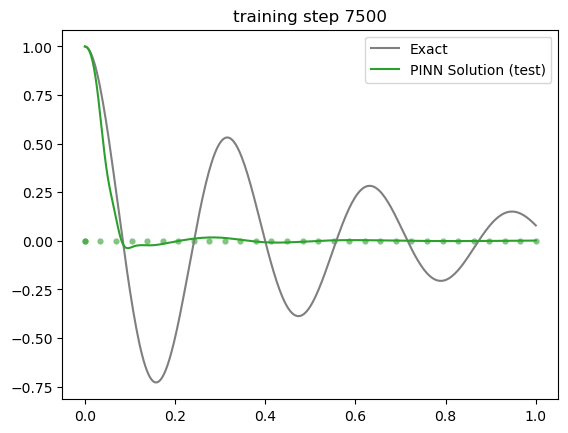

physics loss is :  0.00017890021263156086
MSE loss is  0.0006337453378364444


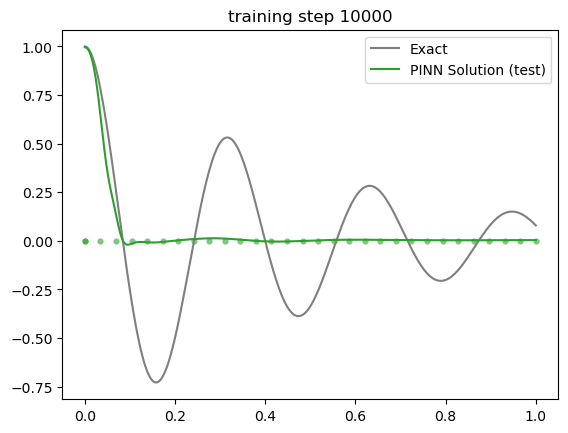

physics loss is :  6.55641924822703e-05
MSE loss is  0.0007059179479256272


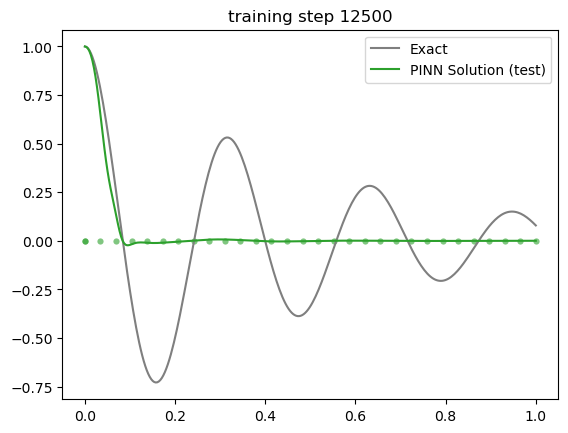

physics loss is :  3.555398143362254e-05
MSE loss is  0.0007468401454389095


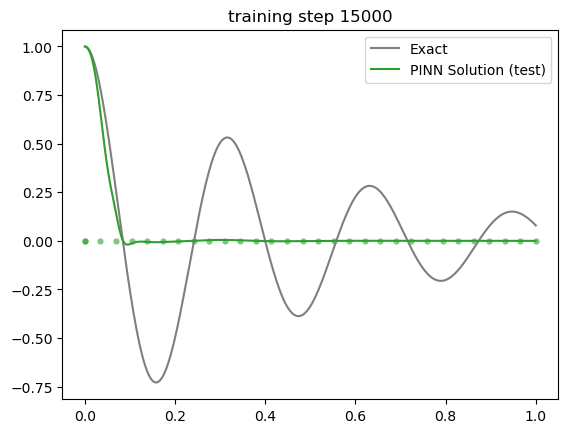

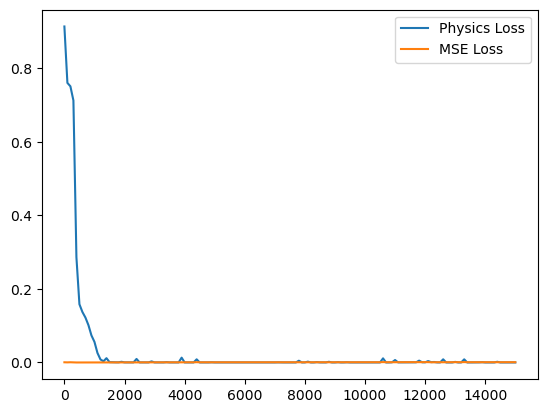

In [88]:
torch.manual_seed(123)


pinn = FCN(1,1,32,3)

t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimizer = torch.optim.Adam(pinn.parameters(), lr = 1e-3)
physics_loss = []
MSE_loss = []
iteration = []
for i in range(15001):


    optimizer.zero_grad()
    lambda1, lambda2 = 1e-1, 1e-4

    # Boundary loss
    u = pinn(t_boundary)

    loss1 = (torch.squeeze(u) - 1)**2
    du = torch.autograd.grad(u,t_boundary, torch.ones_like(u), create_graph = True)[0]
    loss2 = (torch.squeeze(du)- 0)**2
   # physics loss

    u = pinn(t_physics)
    du = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph = True)[0]
    du2 = torch.autograd.grad(du, t_physics, torch.ones_like(du), create_graph = True)[0]

    loss3 = torch.mean( (du2+ mu*du + k*u)**2)

    loss =  loss1 + lambda1*loss2 + lambda2*loss3
    u_physics = exact_solution(d,w0,t_physics)
    #points_loss = nn.MSELoss()
    #loss = points_loss(u_physics, u)
    loss.backward()
    optimizer.step()
    if i % 100 == 0: 
        physics_loss.append(loss.detach())
        MSE_loss.append((torch.mean(u- u_physics)**2).detach())
        iteration.append(i)
    if i % 2500 == 0:
        print(f"physics loss is :  {loss}")
        print(f"MSE loss is  {torch.mean(u- u_physics)**2}")

        u = pinn(t_test).detach()
        #plt.figure(figsize = (6,2,5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0],s=20,lw=0, color = "tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0],s=20,lw=0, color = "tab:green", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0],label = "Exact",color = "tab:grey")
        plt.plot(t_test[:,0], u[:,0], label = "PINN Solution (test)", color = "tab:green")
        #plt.plot(t_physics.detach()[:,0], u.detach()[:,0], label = "PINN Solution (train)", color = "tab:blue")
        plt.title(f"training step {i}")
        plt.legend()
        plt.show()

plt.plot(iteration,physics_loss, label = "Physics Loss")
plt.plot(iteration, MSE_loss, label = "MSE Loss")
plt.legend()
plt.show()

### Sample easy ODE
$$y^{'} = cos(x)$$
$$y(0) = 2$$
$$y(x) = sin(x) + 2$$ 

In [115]:
def exact_solution(x):
    return torch.sin(x) + 2 

C:\Users\abd-_\AppData\Local\Temp\ipykernel_4668\3050402199.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_exact = torch.tensor(exact_solution(t_test))
C:\Users\abd-_\AppData\Local\Temp\ipykernel_4668\3050402199.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_physics = torch.tensor(exact_solution(t_physics))


physics loss is :  8.098373172060747e-08
Boundary loss is: 4.501884937286377
total loss is: 4.501884937286377
MSE loss is  4.31013822555542


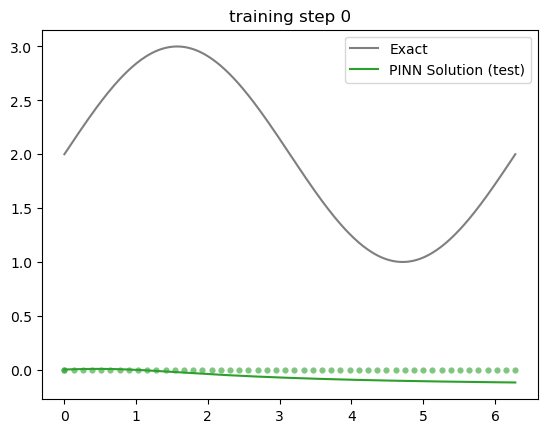

physics loss is :  8.098373172060747e-08
Boundary loss is: 0.10740714520215988
total loss is: 0.10740714520215988
MSE loss is  0.003646076889708638


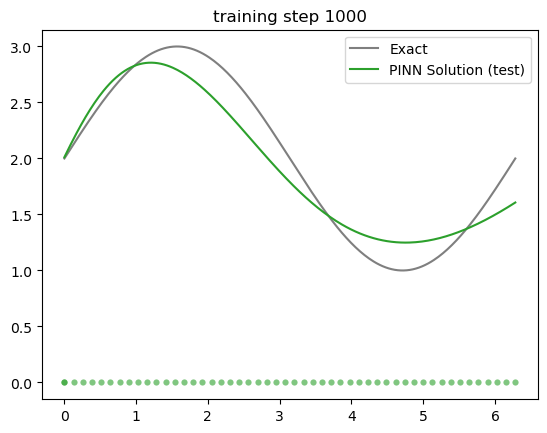

physics loss is :  8.098373172060747e-08
Boundary loss is: 0.014559182338416576
total loss is: 0.014559182338416576
MSE loss is  0.0011378329945728183


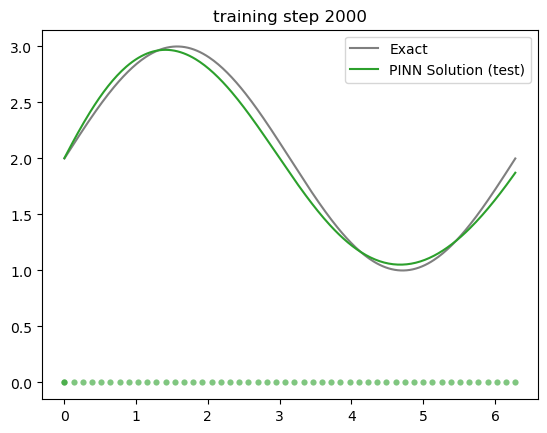

physics loss is :  8.098373172060747e-08
Boundary loss is: 0.0010904917726293206
total loss is: 0.0010904917726293206
MSE loss is  7.978162102517672e-06


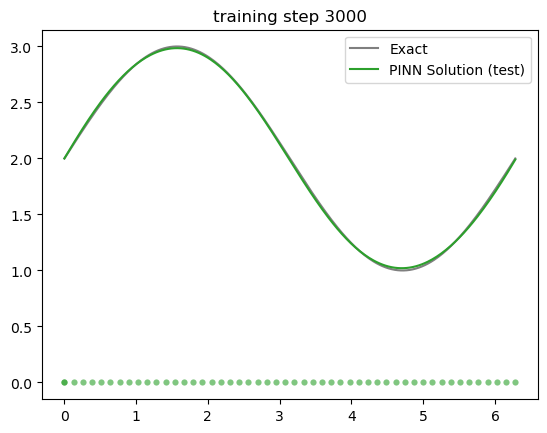

physics loss is :  8.098373172060747e-08
Boundary loss is: 0.0005464805290102959
total loss is: 0.0005464805290102959
MSE loss is  4.061048912262777e-06


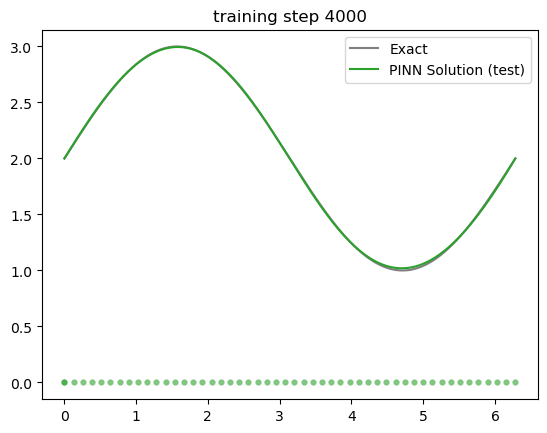

physics loss is :  8.098373172060747e-08
Boundary loss is: 0.00025894842110574245
total loss is: 0.00025894842110574245
MSE loss is  4.226420969644096e-06


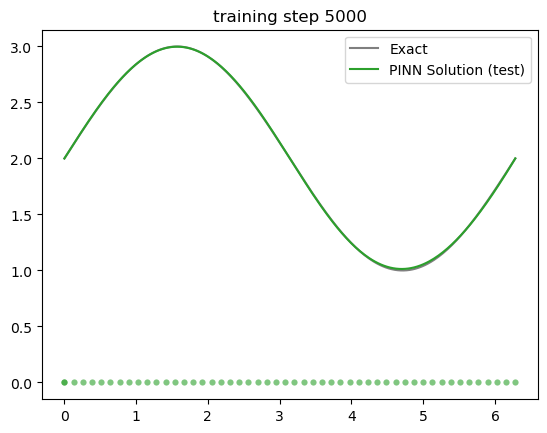

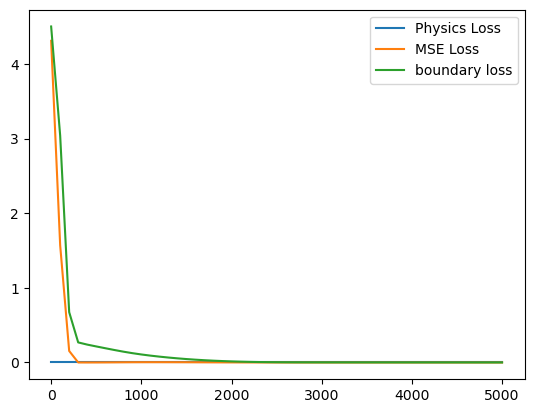

In [116]:
#torch.manual_seed(123)
pinn = FCN(1,1,32,4)

t_boundary = torch.tensor(0., requires_grad = True).view(-1,1)
t_physics = torch.linspace(0,2*torch.pi,50, requires_grad = True).view(-1,1)
t_test = torch.linspace(0,2*torch.pi,300).view(-1,1)
u_exact = torch.tensor(exact_solution(t_test))
optimizer = torch.optim.Adam(pinn.parameters(), lr = 1e-4)
physics_loss = []
MSE_loss = []
iteration = []
boundary_loss = []
for i in range(5001):
    optimizer.zero_grad()
    lambda1, lambda2 = 1e-1, 1e-4

    # Boundary loss
    u = pinn(t_boundary)
    loss1 = torch.squeeze(u-2)**2
    
   # physics loss

    u = pinn(t_physics)
    du = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph = True)[0]

    loss2 = torch.mean( (du - torch.cos(t_physics))**2  )

    loss = loss1 +  loss2 
    u_physics = torch.tensor(exact_solution(t_physics))
    #points_loss = nn.MSELoss()
    #loss = points_loss(u_physics, u)
    loss.backward()
    optimizer.step()
    if i % 100 == 0: 
        boundary_loss.append(loss1.detach() + loss2.detach())
        physics_loss.append(loss3.detach())
        MSE_loss.append((torch.mean(u- u_physics)**2).detach())
        iteration.append(i)
    if i % 1000 == 0:
        print(f"physics loss is :  {loss3}")
        print(f"Boundary loss is: {loss1+loss2}")
        print(f"total loss is: {loss}")
        print(f"MSE loss is  {torch.mean(u- u_physics)**2}")
        u = pinn(t_test).detach()
        #plt.figure(figsize = (6,2,5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0],s=20,lw=0, color = "tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0],s=20,lw=0, color = "tab:green", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0],label = "Exact",color = "tab:grey")
        plt.plot(t_test[:,0], u[:,0], label = "PINN Solution (test)", color = "tab:green")
        #plt.plot(t_physics.detach()[:,0], u.detach()[:,0], label = "PINN Solution (train)", color = "tab:blue")
        plt.title(f"training step {i}")
        plt.legend()
        plt.show()

plt.plot(iteration,physics_loss, label = "Physics Loss")
plt.plot(iteration, MSE_loss, label = "MSE Loss")
plt.plot(iteration, boundary_loss, label = "boundary loss")
plt.legend()
plt.show()